In [6]:
import data_processing
import models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from keras import callbacks
from keras import optimizers
from keras.models import Model
from keras.utils.vis_utils import plot_model

In [7]:
# load pre-trained GloVe
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-07-21 20:04:05--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.11MB/s    in 2m 39s  

2022-07-21 20:06:44 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [8]:
# mount Google Drive
ROOT = "/content/drive"
drive.mount(ROOT)

Mounted at /content/drive


In [9]:
# read csv in as df
inputPath = '/content/drive/MyDrive/GitHub/Home/Financial/Data/pos_expenses_data1.csv'
df = data_processing.load_purchase_attributes(inputPath)
df.head()

,Location,Description,Cost,Category,Day,Month,Year
0,BurgerKing,dinner,2.19,restaurant,15,May,2019
1,Dennys,late night/early morning food for both sam and i,24.76,restaurant,17,May,2019
2,Dennys,tip,4.95,restaurant,17,May,2019
3,Wawa,moving truck fuel,27.50,transportation,17,May,2019
4,Exxon,moving truck fuel,78.25,transportation,17,May,2019


In [10]:
# define data types for columns
new_df_schema = {
'Location': df['Location'].astype(str),
'Description': df['Description'].astype(str),
'Cost': pd.to_numeric(df['Cost']),
'Category': df['Category'].astype(str),
'Day': df['Day'].astype(str),
'Month': df['Month'].astype(str),
'Year': df['Year'].astype(str),
}

# update the data types
df = pd.DataFrame(new_df_schema)

In [11]:
# drop Category and Description data for mlp
X_MLP = df.drop(['Description', 'Category'], axis=1)
# separate Description data for cnn
X_CNN = df['Description']
# set trainY and testY to Category
Y = df['Category']
# get classes from Category
class_names = pd.unique(df['Category'])

In [12]:
# partition the data into training and testing splits using 75% of the data for 
# training and the remaining 25% for testing
split = train_test_split(X_MLP, X_CNN, Y, test_size=0.25, random_state=42)
(trainX_MLP, testX_MLP, trainX_CNN, testX_CNN, trainY, testY) = split
# process the purchase attributes data by performing min-max scaling on
# continuous features, one-hot encoding on categorical features, and then
# finally concatenating them together
(trainX_MLP, testX_MLP) = data_processing.process_purchase_attributes(X_MLP, trainX_MLP, testX_MLP)
X = data_processing.process_purchase_attributes_all(X_MLP)
# one-hot encode Y
Y = np.array(Y).reshape(-1, 1)
trainY = np.array(trainY).reshape(-1, 1)
testY = np.array(testY).reshape(-1, 1)
(trainY, testY) = data_processing.process_purchase_labels(Y, trainY, testY)

In [13]:
# process Description data and create embedding layer for cnn
voc, word_index, vectorizer = data_processing.create_vocab_index(trainX_CNN)
embeddings_index = data_processing.create_embeddings_index()
num_tokens, embedding_dim, embedding_matrix = data_processing.create_embedding_matrix(
    voc, word_index, embeddings_index)

In [14]:
# vectorize cnn input
trainX_CNN = vectorizer(np.array([[s] for s in trainX_CNN])).numpy()
testX_CNN = vectorizer(np.array([[s] for s in testX_CNN])).numpy()

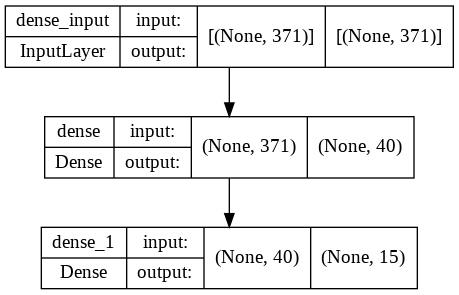

In [15]:
# create the MLP and CNN models
mlp = models.create_mlp(trainX_MLP.shape[1], class_names)
plot_model(mlp, to_file='mlp_plot.png', show_shapes=True, show_layer_names=True)

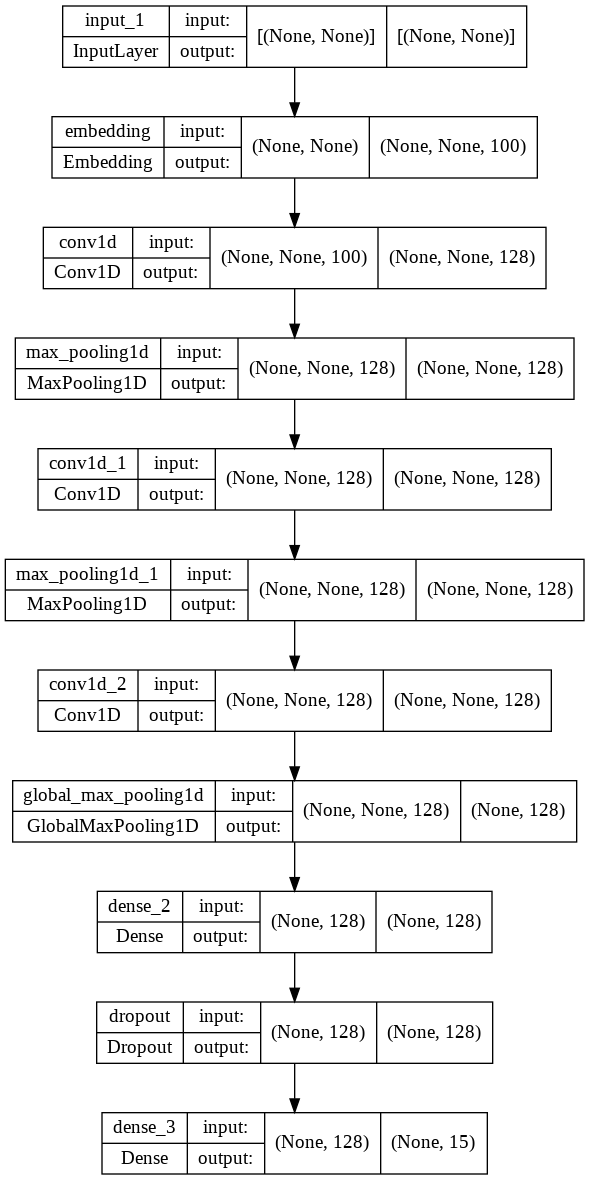

In [16]:
cnn = models.create_cnn(num_tokens, embedding_dim, embedding_matrix, class_names, 128)
plot_model(cnn, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
# compile the model using categorical crossentropy loss
mlp.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
# train the model
mlp_history = mlp.fit(
	x=trainX_MLP, y=trainY,
	validation_data=(testX_MLP, testY),
	epochs=20, batch_size=64)
# make predictions on the testing data
preds = mlp.predict(testX_MLP)

Epoch 1/20
34/34 [==============================] - 1s 8ms/step - loss: 2.5823 - acc: 0.3485 - val_loss: 2.4323 - val_acc: 0.5352
Epoch 2/20
34/34 [==============================] - 0s 3ms/step - loss: 2.2374 - acc: 0.5200 - val_loss: 1.9851 - val_acc: 0.5310
Epoch 3/20
34/34 [==============================] - 0s 3ms/step - loss: 1.7905 - acc: 0.5176 - val_loss: 1.6163 - val_acc: 0.5310
Epoch 4/20
34/34 [==============================] - 0s 3ms/step - loss: 1.5602 - acc: 0.5176 - val_loss: 1.4964 - val_acc: 0.5310
Epoch 5/20
34/34 [==============================] - 0s 3ms/step - loss: 1.4565 - acc: 0.5186 - val_loss: 1.4178 - val_acc: 0.5380
Epoch 6/20
34/34 [==============================] - 0s 3ms/step - loss: 1.3689 - acc: 0.5500 - val_loss: 1.3452 - val_acc: 0.5831
Epoch 7/20
34/34 [==============================] - 0s 3ms/step - loss: 1.2893 - acc: 0.6003 - val_loss: 1.2802 - val_acc: 0.6268
Epoch 8/20
34/34 [==============================] - 0s 3ms/step - loss: 1.2163 - acc: 0.64

In [18]:
# compile the model using categorical crossentropy loss
cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
# train the model
cnn_history = cnn.fit(
	x=trainX_CNN, y=trainY,
	validation_data=(testX_CNN, testY),
	epochs=20, batch_size=64)
# make predictions on the testing data
preds = cnn.predict(testX_CNN)

Epoch 1/20
34/34 [==============================] - 5s 119ms/step - loss: 1.8101 - acc: 0.5369 - val_loss: 1.1162 - val_acc: 0.6859
Epoch 2/20
34/34 [==============================] - 4s 112ms/step - loss: 1.0099 - acc: 0.7022 - val_loss: 0.8364 - val_acc: 0.7493
Epoch 3/20
34/34 [==============================] - 5s 162ms/step - loss: 0.8278 - acc: 0.7473 - val_loss: 0.7719 - val_acc: 0.7662
Epoch 4/20
34/34 [==============================] - 4s 114ms/step - loss: 0.7026 - acc: 0.7868 - val_loss: 0.6771 - val_acc: 0.7887
Epoch 5/20
34/34 [==============================] - 5s 156ms/step - loss: 0.6039 - acc: 0.8182 - val_loss: 0.6130 - val_acc: 0.8169
Epoch 6/20
34/34 [==============================] - 7s 190ms/step - loss: 0.4886 - acc: 0.8586 - val_loss: 0.5488 - val_acc: 0.8310
Epoch 7/20
34/34 [==============================] - 4s 114ms/step - loss: 0.4202 - acc: 0.8779 - val_loss: 0.5249 - val_acc: 0.8437
Epoch 8/20
34/34 [==============================] - 4s 114ms/step - loss: 0.

epochs=20, batch_size=64
MLP final test accuracy: 0.7352112531661987
CNN final test accuracy: 0.8802816867828369


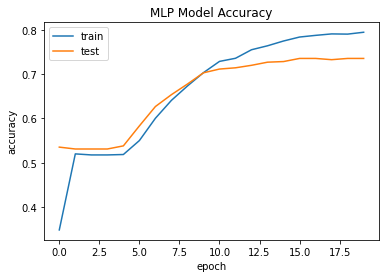

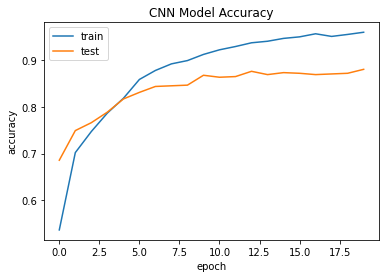

MLP final test loss: 0.8839819431304932
CNN final test loss: 0.5539752244949341


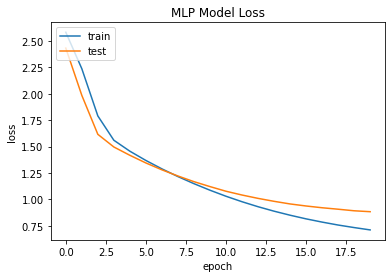

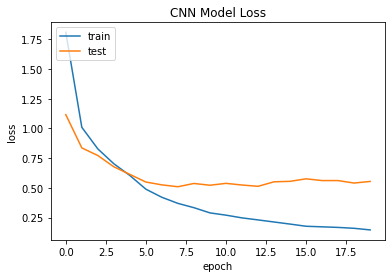

In [19]:
print('epochs=20, batch_size=64')
score_mlp = mlp.evaluate(testX_MLP, testY, verbose=0)
score_cnn = cnn.evaluate(testX_CNN, testY, verbose=0)

# summarize history for accuracy
print('MLP final test accuracy:', score_mlp[1])
print('CNN final test accuracy:', score_cnn[1])
# plot MLP accuracy
plt.plot(mlp_history.history['acc'])
plt.plot(mlp_history.history['val_acc'])
plt.title('MLP Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# plot CNN accuracy
plt.plot(cnn_history.history['acc'])
plt.plot(cnn_history.history['val_acc'])
plt.title('CNN Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
print('MLP final test loss:', score_mlp[0])
print('CNN final test loss:', score_cnn[0])
# plot MLP loss
plt.plot(mlp_history.history['loss'])
plt.plot(mlp_history.history['val_loss'])
plt.title('MLP Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# plot CNN loss
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()